In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
import time
from itertools import product
from sklearn.preprocessing import LabelEncoder

In [18]:
training_set = pd.read_csv('drive/My Drive/Stats_Data/sales_train.csv')
items = pd.read_csv('drive/My Drive/Stats_Data/items.csv')
categories = pd.read_csv('drive/My Drive/Stats_Data/item_categories.csv')
shops = pd.read_csv('drive/My Drive/Stats_Data/shops.csv')

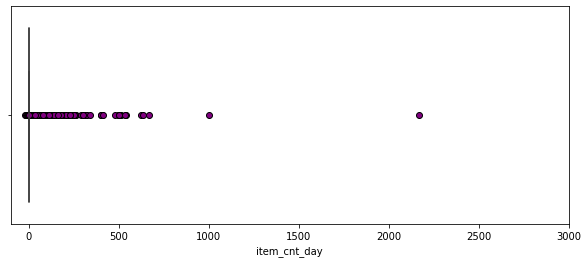

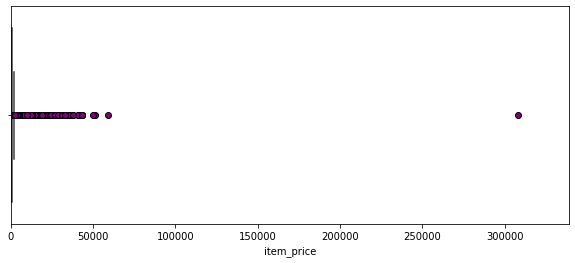

In [19]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=training_set.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(training_set.item_price.min(), training_set.item_price.max()*1.1)
sns.boxplot(x=training_set.item_price, flierprops=flierprops)

In [20]:
# Remove outlier
training_set = training_set[(training_set.item_price < 300000 )& (training_set.item_cnt_day < 1000)]
# remove negative item price

In [ ]:
training_set.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [21]:
train = training_set[(training_set['date_block_num']>=12)&(training_set['date_block_num']<33)]
test_last_month = training_set[(training_set['date_block_num']==33)]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1267562,02.01.2014,12,54,10297,749.0,1.0
1267563,10.01.2014,12,54,10297,749.0,1.0
1267564,24.01.2014,12,54,10297,749.0,1.0
1267565,24.01.2014,12,54,10296,1599.0,1.0
1267566,31.01.2014,12,54,10297,749.0,1.0
...,...,...,...,...,...,...
2882330,27.09.2015,32,25,21022,1799.0,1.0
2882331,19.09.2015,32,25,21105,1799.0,1.0
2882332,30.09.2015,32,25,21088,1299.0,1.0
2882333,08.09.2015,32,25,20990,1299.0,1.0


In [ ]:
train.isnull().values.any()
test_last_month.isnull().values.any()
items.isnull().values.any()
categories.isnull().values.any()
shops.isnull().values.any()

False

Dataset does not consist of any of NaN values.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


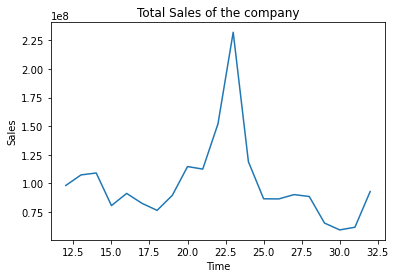

In [22]:
# add revenue to train df
train["revenue"] = train['item_cnt_day'] * train['item_price']
total_sales = train.groupby(['date_block_num'])["revenue"].sum()
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(total_sales);

In [ ]:
##import statsmodels.api as sm
##res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
##plt.figure(figsize=(16,12))
##fig = res.plot()
##fig.show()

In [23]:
##Storing unique pairs of Shop ID and Item ID
##create dataframe as product of item/shop pairs within each month in the train set
data = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(12,33):
    sales = train[train.date_block_num == i]
    data.append(np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )
data = pd.DataFrame(np.vstack(data), columns = cols )
data["date_block_num"] = data["date_block_num"].astype(np.int8)
data["shop_id"] = data["shop_id"].astype(np.int8)
data["item_id"] = data["item_id"].astype(np.int16)
data.sort_values( cols, inplace = True)
data

,date_block_num,shop_id,item_id
67346,12,2,27
63242,12,2,30
63803,12,2,31
63507,12,2,32
63518,12,2,33
...,...,...,...
6046391,32,59,22162
6046385,32,59,22163
6046392,32,59,22164
6047329,32,59,22166


In [24]:
data_grouped = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg({"item_cnt_day":["sum"]} )
data_grouped.columns = ["item_cnt_month"]
data_grouped.reset_index( inplace = True)
cols  = ["date_block_num", "shop_id", "item_id"]
data = pd.merge(data, data_grouped, on = cols, how = "left")
data["item_cnt_month"].fillna(0).astype(np.float16)
data.fillna( 0, inplace = True )
data

,date_block_num,shop_id,item_id,item_cnt_month
0,12,2,27,0.0
1,12,2,30,0.0
2,12,2,31,0.0
3,12,2,32,1.0
4,12,2,33,1.0
...,...,...,...,...
6186917,32,59,22162,0.0
6186918,32,59,22163,0.0
6186919,32,59,22164,0.0
6186920,32,59,22166,0.0


In [25]:
##Create a test set for month 33
test_grouped=training_set.loc[(training_set['date_block_num']==33), ["date_block_num", "shop_id", "item_id","item_cnt_day"]]
test = test_grouped.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} ).sort_values(by='shop_id',ascending=True)
test.columns = ["test_item_cnt_month"]
test.reset_index( inplace = True)
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)
test["test_item_cnt_month"] = test.test_item_cnt_month.astype(np.int16)
data = pd.concat([data, test], ignore_index=True, sort=False, keys=cols)
data.fillna( 0, inplace = True )
data

,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month
0,12,2,27,0.0,0.0
1,12,2,30,0.0,0.0
2,12,2,31,0.0,0.0
3,12,2,32,1.0,0.0
4,12,2,33,1.0,0.0
...,...,...,...,...,...
6218448,33,59,5811,0.0,1.0
6218449,33,59,5675,0.0,2.0
6218450,33,59,5672,0.0,1.0
6218451,33,59,6126,0.0,1.0


In [26]:
data.fillna( 0, inplace = True )
data

,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month
0,12,2,27,0.0,0.0
1,12,2,30,0.0,0.0
2,12,2,31,0.0,0.0
3,12,2,32,1.0,0.0
4,12,2,33,1.0,0.0
...,...,...,...,...,...
6218448,33,59,5811,0.0,1.0
6218449,33,59,5675,0.0,2.0
6218450,33,59,5672,0.0,1.0
6218451,33,59,6126,0.0,1.0


In [27]:
# Add shop, items and categories data onto matrix df.
data = pd.merge(data, shops, on = ["shop_id"], how = "left" )
data = pd.merge(data, items, on = ["item_id"], how = "left")
data = pd.merge(data, categories, on = ["item_category_id"], how = "left" )
data.drop( ['shop_name', 'item_name', 'item_category_name'], axis = 1, inplace = True )

In [28]:
#Adding Lag features to the dataframe
#Lag Function Definition
def lag_feature(df,lags, cols ):
    for col in cols:
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
  
# Add item_cnt_month lag features. 
data = lag_feature(data, [1,2,3], ["item_cnt_month"])


In [29]:
data = lag_feature(data, [6,12], ["item_cnt_month"])

In [30]:

##item_cnt_month_lag_1,item_cnt_month_lag_2 and item_cnt_month_lag_3 displays sales of last three months in each column
display(data.loc[(data['date_block_num']==21)&(data['shop_id']==59)&(data['item_id']==5672)])
display(data.loc[(data['date_block_num']==31)&(data['shop_id']==59)&(data['item_id']==5672)])
display(data.loc[(data['date_block_num']==31)&(data['shop_id']==59)&(data['item_id']==5672)])
display(data.loc[(data['date_block_num']==30)&(data['shop_id']==59)&(data['item_id']==5672)])
display(data.loc[(data['date_block_num']==33)&(data['shop_id']==59)&(data['item_id']==5672)])
data.fillna( 0, inplace = True )

,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
3288395,21,59,5672,1.0,0.0,3,0.0,2.0,4.0,1.0,NaN


,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
5964465,31,59,5672,1.0,0.0,3,0.0,0.0,1.0,0.0,2.0


,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
5964465,31,59,5672,1.0,0.0,3,0.0,0.0,1.0,0.0,2.0


,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
5749806,30,59,5672,0.0,0.0,3,0.0,1.0,0.0,0.0,4.0


,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
6218450,33,59,5672,0.0,1.0,3,4.0,1.0,0.0,0.0,1.0


In [31]:
# Add the previous month's average item_cnt.
data_grouped = data.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
data_grouped.columns = ["monthly_avg_item_cnt"]
data_grouped.reset_index(inplace = True)
data = pd.merge(data, data_grouped, on = ["date_block_num"], how = "left")
data.monthly_avg_item_cnt = data["monthly_avg_item_cnt"].astype(np.float16)
data = lag_feature( data, [1], ["monthly_avg_item_cnt"] )
data.drop( ["monthly_avg_item_cnt"], axis = 1, inplace = True )

In [32]:
data.fillna( 0, inplace = True )
data

,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,monthly_avg_item_cnt_lag_1
0,12,2,27,0.0,0.0,19,0.0,0.0,0.0,0.0,0.0,0.000000
1,12,2,30,0.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.000000
2,12,2,31,0.0,0.0,37,0.0,0.0,0.0,0.0,0.0,0.000000
3,12,2,32,1.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.000000
4,12,2,33,1.0,0.0,37,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6218448,33,59,5811,0.0,1.0,30,0.0,0.0,0.0,1.0,2.0,0.333252
6218449,33,59,5675,0.0,2.0,3,1.0,2.0,0.0,0.0,0.0,0.333252
6218450,33,59,5672,0.0,1.0,3,4.0,1.0,0.0,0.0,1.0,0.333252
6218451,33,59,6126,0.0,1.0,30,0.0,1.0,0.0,1.0,0.0,0.333252


In [33]:
# Add lag values of item_cnt_month for month / item_id.
data_grouped = data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
data_grouped.columns = [ 'monthly_item_avg_item_cnt' ]
data_grouped.reset_index(inplace=True)
data = pd.merge(data, data_grouped, on=['date_block_num','item_id'], how='left')
data.monthly_item_avg_item_cnt = data['monthly_item_avg_item_cnt'].astype(np.float16)
data = lag_feature(data, [1,2,3,6,12], ['monthly_item_avg_item_cnt'])
data.drop(['monthly_item_avg_item_cnt'], axis=1, inplace=True)

In [34]:
data.fillna( 0, inplace = True )


In [35]:
# Add lag values for item_cnt_month for month/shop/item.
data_grouped = data.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
data_grouped.columns = ["monthly_shop_item_avg_item_cnt"]
data_grouped.reset_index(inplace = True)
data = pd.merge(data, data_grouped, on = ["date_block_num","shop_id","item_id"], how = "left")
data.monthly_shop_item_avg_item_cnt = data["monthly_shop_item_avg_item_cnt"].astype(np.float16)
data = lag_feature(data, [1,2,3,6,12], ["monthly_shop_item_avg_item_cnt"] )
data.drop( ["monthly_shop_item_avg_item_cnt"], axis = 1, inplace = True )
data.fillna( 0, inplace = True )


In [ ]:
# Add lag values for item_cnt_month for every month / shop combination.
data_grouped = data.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
data_grouped.columns = ["monthly_shop_avg_item_cnt"]
data_grouped.reset_index(inplace = True)
data = pd.merge(data, data_grouped, on = ["date_block_num","shop_id"], how = "left")
data.monthly_shop_avg_item_cnt = data["monthly_shop_avg_item_cnt"].astype(np.float16)
data = lag_feature( data, [1,2,3], ["monthly_shop_avg_item_cnt"] )
data.drop( ["monthly_shop_avg_item_cnt"], axis = 1, inplace = True )
data.fillna( 0, inplace = True )


In [ ]:

# Add average item price on to matix df., add lag values of item price per month
# Add delta price values - how current month average pirce relates to global average.
data_grouped = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
data_grouped.columns = ["item_avg_item_price"]
data_grouped.reset_index(inplace = True)
data = pd.merge(data, data_grouped, on = ["item_id"], how = "left" )
data["item_avg_item_price"] = data.item_avg_item_price.astype(np.float16)
group_mean = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group_mean.columns = ["montly_item_avg_item_price"]
group_mean.reset_index(inplace = True)
data = pd.merge(data,group_mean, on = ["date_block_num","item_id"], how = "left")
data["montly_item_avg_item_price"] = data.montly_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
data = lag_feature( data, lags, ["montly_item_avg_item_price"] )


In [ ]:
for i in lags:
    data["delta_price_lag_" + str(i) ] = (data["montly_item_avg_item_price_lag_" + str(i)]- data["item_avg_item_price"] )/ data["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

data["delta_price_lag"] = data.apply(select_trends, axis = 1)
data["delta_price_lag"] = data.delta_price_lag.astype( np.float16 )
data.fillna( 0, inplace = True )



In [ ]:
features_to_drop = ["item_avg_item_price", "montly_item_avg_item_price"]
for i in lags:
    features_to_drop.append("montly_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
data.drop(features_to_drop, axis = 1, inplace = True)


In [ ]:
data.fillna( 0, inplace = True )
data

,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,monthly_avg_item_cnt_lag_1,monthly_item_avg_item_cnt_lag_1,monthly_item_avg_item_cnt_lag_2,monthly_item_avg_item_cnt_lag_3,monthly_item_avg_item_cnt_lag_6,monthly_item_avg_item_cnt_lag_12,monthly_shop_item_avg_item_cnt_lag_1,monthly_shop_item_avg_item_cnt_lag_2,monthly_shop_item_avg_item_cnt_lag_3,monthly_shop_item_avg_item_cnt_lag_6,monthly_shop_item_avg_item_cnt_lag_12,monthly_shop_avg_item_cnt_lag_1,monthly_shop_avg_item_cnt_lag_2,monthly_shop_avg_item_cnt_lag_3,delta_price_lag
0,12,2,27,0.0,0.0,19,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,12,2,30,0.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,12,2,31,0.0,0.0,37,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,12,2,32,1.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,12,2,33,1.0,0.0,37,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6218448,33,59,5811,0.0,1.0,30,0.0,0.0,0.0,1.0,2.0,0.333252,0.209351,0.119019,0.325684,0.319092,0.980957,0.0,0.0,0.0,1.0,2.0,0.179688,0.237671,0.186401,-0.489746
6218449,33,59,5675,0.0,2.0,3,1.0,2.0,0.0,0.0,0.0,0.333252,8.906250,6.976562,0.046509,0.000000,0.000000,1.0,2.0,0.0,0.0,0.0,0.179688,0.237671,0.186401,-0.002541
6218450,33,59,5672,0.0,1.0,3,4.0,1.0,0.0,0.0,1.0,0.333252,1.813477,1.738281,1.372070,2.978516,2.460938,4.0,1.0,0.0,0.0,1.0,0.179688,0.237671,0.186401,0.118530
6218451,33,59,6126,0.0,1.0,30,0.0,1.0,0.0,1.0,0.0,0.333252,0.465088,0.119019,0.069763,0.787109,0.000000,0.0,1.0,0.0,1.0,0.0,0.179688,0.237671,0.186401,-0.263916


In [ ]:
# Add total shop revenue per month to matix df. Add lag values of revenue per month.
# Add delta revenue values - how current month revenue relates to global average.
data_grouped = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
data_grouped.columns = ["monthly_shop_revenue"]
data_grouped.reset_index(inplace = True)
data = pd.merge( data, data_grouped , on = ["date_block_num", "shop_id"], how = "left" )
data['monthly_shop_revenue'] = data['monthly_shop_revenue'].astype(np.float32)
grouped_mean = train.groupby(["shop_id"]).agg({ "revenue":["mean"] })
grouped_mean.columns = ["shop_avg_revenue"]
grouped_mean.reset_index(inplace = True )

data = pd.merge(data,grouped_mean, on = ["shop_id"], how = "left" )
data["shop_avg_revenue"] = data.shop_avg_revenue.astype(np.float32)
data["delta_revenue"] = (data['monthly_shop_revenue'] - data['shop_avg_revenue']) / data['shop_avg_revenue']
data["delta_revenue"] = data["delta_revenue"]. astype(np.float32)

data = lag_feature(data, [1], ["delta_revenue"])
data["delta_revenue_lag_1"] = data["delta_revenue_lag_1"].astype(np.float32)
data.drop( ["monthly_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

# Add month and number of days in each month to matrix df.
data["month"] = data["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
data["days"] = data["month"].map(days).astype(np.int8)
data

# Deleting first 3 months. They do not have lag values populated
data = data[data["date_block_num"] > 3]
data.fillna( 0, inplace = True )


In [ ]:
data.fillna( 0, inplace = True )
data

,date_block_num,shop_id,item_id,item_cnt_month,test_item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,monthly_avg_item_cnt_lag_1,monthly_item_avg_item_cnt_lag_1,monthly_item_avg_item_cnt_lag_2,monthly_item_avg_item_cnt_lag_3,monthly_item_avg_item_cnt_lag_6,monthly_item_avg_item_cnt_lag_12,monthly_shop_item_avg_item_cnt_lag_1,monthly_shop_item_avg_item_cnt_lag_2,monthly_shop_item_avg_item_cnt_lag_3,monthly_shop_item_avg_item_cnt_lag_6,monthly_shop_item_avg_item_cnt_lag_12,monthly_shop_avg_item_cnt_lag_1,monthly_shop_avg_item_cnt_lag_2,monthly_shop_avg_item_cnt_lag_3,delta_price_lag,delta_revenue_lag_1,month,days
0,12,2,27,0.0,0.0,19,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
1,12,2,30,0.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
2,12,2,31,0.0,0.0,37,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
3,12,2,32,1.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
4,12,2,33,1.0,0.0,37,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6218448,33,59,5811,0.0,1.0,30,0.0,0.0,0.0,1.0,2.0,0.333252,0.209351,0.119019,0.325684,0.319092,0.980957,0.0,0.0,0.0,1.0,2.0,0.179688,0.237671,0.186401,-0.489746,901.506836,9,31
6218449,33,59,5675,0.0,2.0,3,1.0,2.0,0.0,0.0,0.0,0.333252,8.906250,6.976562,0.046509,0.000000,0.000000,1.0,2.0,0.0,0.0,0.0,0.179688,0.237671,0.186401,-0.002541,901.506836,9,31
6218450,33,59,5672,0.0,1.0,3,4.0,1.0,0.0,0.0,1.0,0.333252,1.813477,1.738281,1.372070,2.978516,2.460938,4.0,1.0,0.0,0.0,1.0,0.179688,0.237671,0.186401,0.118530,901.506836,9,31
6218451,33,59,6126,0.0,1.0,30,0.0,1.0,0.0,1.0,0.0,0.333252,0.465088,0.119019,0.069763,0.787109,0.000000,0.0,1.0,0.0,1.0,0.0,0.179688,0.237671,0.186401,-0.263916,901.506836,9,31


In [ ]:
import gc
df_data = data.copy()
del data
gc.collect()
X_train = df_data[df_data.date_block_num < 33].drop(['item_cnt_month','test_item_cnt_month'], axis=1)
Y_train = df_data[df_data.date_block_num < 33]['item_cnt_month']


X_test = df_data[df_data.date_block_num == 33].drop(['item_cnt_month','test_item_cnt_month'], axis=1)
Y_test= df_data[df_data.date_block_num == 33]['test_item_cnt_month']
X_test
del df_data
gc.collect();

In [ ]:
Y_train = Y_train.clip(0, 20)
Y_test = Y_test.clip(0, 20)
Y_train
Y_test


6186922    1.0
6186923    1.0
6186924    1.0
6186925    1.0
6186926    1.0
          ... 
6218448    1.0
6218449    2.0
6218450    1.0
6218451    1.0
6218452    1.0
Name: test_item_cnt_month, Length: 31531, dtype: float64

In [ ]:
model = XGBRegressor(
      max_depth = 10,
                                            n_estimators = 25,
                                            min_child_weight = 0.5, 
                                            subsample = 0.6, 
                                           cosample_bytree = 0.6,
                                           alpha = 0.1,
                                           eta = 0.1, 
                                           seed = 42)


In [ ]:
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train)],   early_stopping_rounds = 20)

[09:23:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:39] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.13059
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.08997
[2]	validation_0-rmse:1.05391
[3]	validation_0-rmse:1.02347
[4]	validation_0-rmse:0.999253
[5]	validation_0-rmse:0.977432
[6]	validation_0-rmse:0.958601
[7]	validation_0-rmse:0.941255
[8]	validation_0-rmse:0.927798
[9]	validation_0-rmse:0.916602
[10]	validation_0-rmse:0.90609
[11]	validation_0-rmse:0.898235
[12]	validation_0-rmse:0.886356
[13]	validation_0-rmse:0.879535
[14]	validation_0-rmse:0.872508
[15]	validation_0-rmse:0.86722
[16]	validation_0-rmse:0.861556
[17]	validation_0-rmse:0.857789
[18]	validation_0-rmse:0.851501
[1

XGBRegressor(alpha=0.1, cosample_bytree=0.6, eta=0.1, max_depth=10,
             min_child_weight=0.5, n_estimators=25, seed=42, subsample=0.6)

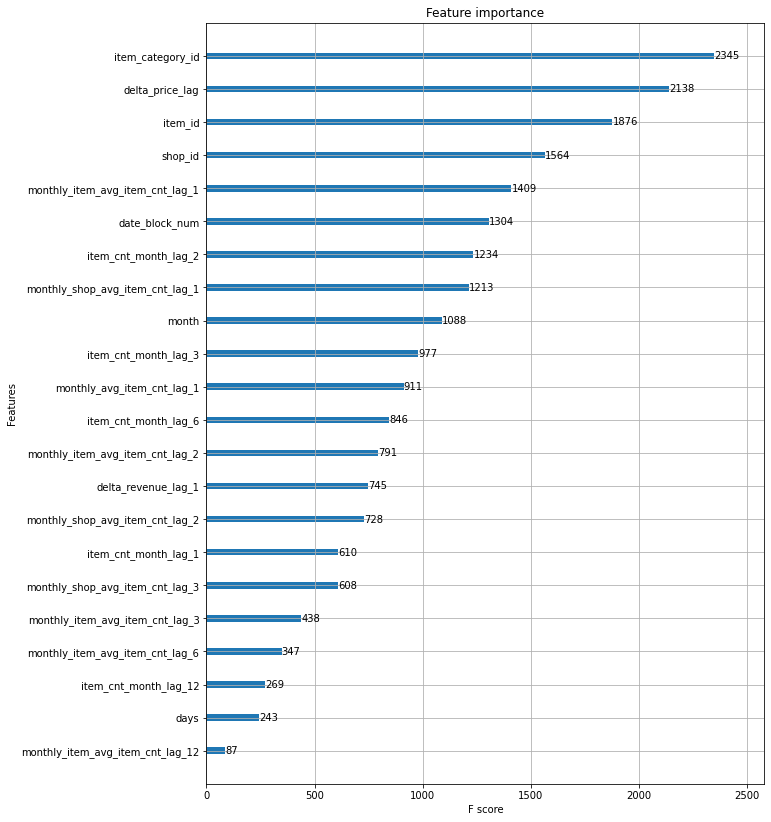

In [ ]:
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))


In [ ]:
Y_pred = model.predict(X_test).clip(0, 20)


In [ ]:
from sklearn.metrics import mean_absolute_error  
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('Test rmse:', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("Mean Absolute Error: ", mean_absolute_error(Y_test,Y_pred))

#print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(y_test,y_pred))

print("r2 score: ", r2_score(Y_test,Y_pred))

print("Mean Squared Error: ", mean_squared_error(Y_test,Y_pred))


Test rmse: 2.3861100663710095
Mean Absolute Error:  1.331646423864265
r2 score:  0.1160433829309716
Mean Squared Error:  5.6935212488370635


In [ ]:
Y_pred

array([0.        , 0.29191348, 0.2731911 , ..., 1.4364452 , 0.35565883,
       0.819958  ], dtype=float32)

6186922    1.0
6186923    1.0
6186924    1.0
6186925    1.0
6186926    1.0
          ... 
6218448    1.0
6218449    2.0
6218450    1.0
6218451    1.0
6218452    1.0
Name: test_item_cnt_month, Length: 31531, dtype: float64

In [ ]:
Y_train = Y_train.clip(0, 20)
Y_test = Y_test.clip(0, 20)

Y_train
Y_test


6186922    1.0
6186923    1.0
6186924    1.0
6186925    1.0
6186926    1.0
          ... 
6218448    1.0
6218449    2.0
6218450    1.0
6218451    1.0
6218452    1.0
Name: test_item_cnt_month, Length: 31531, dtype: float64